In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d


from star_hard_constraints.sdf import SDFLeaf
from star_hard_constraints.models import SimpleConstrainedNN, ESConstrainedNN
from star_hard_constraints.layers import RayMarchingProjectOntoBoundaryLayer

    Two binary variables: A and B.
    Independency:
        P(A, B) = P(A) * P(B).
    Let P(A, B) = p_1,
        P(A, -B) = p_2,
        P(-A, B) = p_3,
        P(-A, -B) = p_4.
    Sum p_i = 1.

    Probabilities of elementary events are:
        P(A) = P(A, B) + P(A, -B) = p_1 + p_2;
        P(B) = P(A, B) + P(-A, B) = p_1 + p_3;
    From the independency property:
        p_1 = P(A, B) = P(A) * P(B) = (p_1 + p_2) * (p_1 + p_3).

    The constraint set:
        p_1 = (p_1 + p_2) * (p_1 + p_3);
        0 <= p_i <= 1;
        sum p_i = 1 from i = 1 to 4.

## Plot Surface (Exact Solution)

In [2]:
def get_proba_surface():
    shape = (80, 80)
    grid = np.stack(
        np.meshgrid(
            *[
                np.linspace(0.0, 1.0, s)
                for s in shape
            ],
            indexing='ij',
        ),
        axis=-1
    ).reshape(-1, 2)
    
    z = (-grid[:, 0] * grid[:, 1] + grid[:, 0] - grid[:, 0] ** 2) / \
        np.clip(grid[:, 0] + grid[:, 1], 1.e-9, np.inf)
    
    z[z < 0] = np.nan
    z[z > 1] = np.nan
    z[z + grid[:, 0] + grid[:, 1] > 1] = np.nan
    return grid[:, 0].reshape(shape), grid[:, 1].reshape(shape), z.reshape(shape)

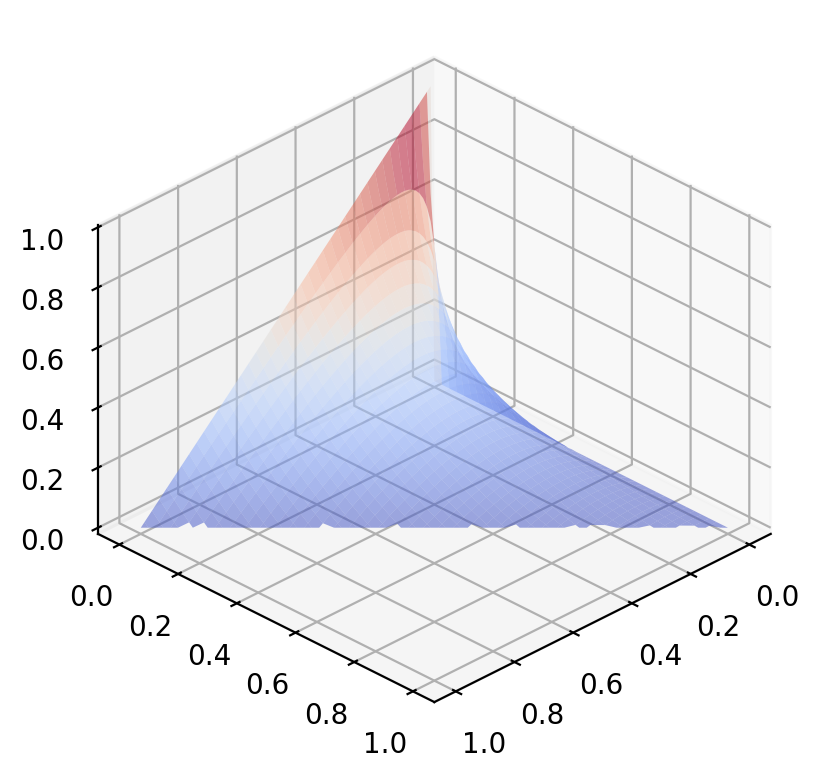

In [3]:
surface = get_proba_surface()

ax = plt.figure(dpi=200).add_subplot(projection='3d')
ax.plot_surface(
    *surface,
    cmap=cm.coolwarm,
    alpha=0.5
)
ax.set_proj_type('ortho')
ax.view_init(elev=30., azim=45)

## SDF of the Surface

In [4]:
class SDFProbabilitiesOfTwoBinaryIndependentVariables(SDFLeaf):
    """
    Two binary variables: A and B.
    Independency:
        P(A, B) = P(A) * P(B).
    Let P(A, B) = p_1,
        P(A, -B) = p_2,
        P(-A, B) = p_3,
        P(-A, -B) = p_4.
    Sum p_i = 1.

    Probabilities of elementary events are:
        P(A) = P(A, B) + P(A, -B) = p_1 + p_2;
        P(B) = P(A, B) + P(-A, B) = p_1 + p_3;
    From the independency property:
        p_1 = P(A, B) = P(A) * P(B) = (p_1 + p_2) * (p_1 + p_3).

    The constraint set:
        p_1 = (p_1 + p_2) * (p_1 + p_3);
        0 <= p_i <= 1;
        sum p_i = 1 from i = 1 to 4.

    In this block we encode only the independency constraint:
        p_1 = (p_1 + p_2) * (p_1 + p_3).

    """
    def leaf(self, xs: torch.Tensor) -> torch.Tensor:
        """
        Args:
            xs: With first three probabilities: (p_1, p_2, p_3).
        """
        p1, p2, p3 = xs[:, 0], xs[:, 1], xs[:, 2]
        return (p1 * (p1 + p2 + p3 - 1) + p2 * p3)


## Neural Network that Maps Input Points onto the Surface

In [5]:
class OntoBoundaryNN(torch.nn.Module):
    def __init__(self, omega, origin, encoder, n_iter: int = 10):
        super().__init__()
        self.omega = omega
        self.origin = origin
        self.encoder = encoder
        self.layer = RayMarchingProjectOntoBoundaryLayer(origin, omega, n_iter=n_iter)

    def forward(self, x):
        ray = self.encoder(x) - self.origin
        proj = self.layer(ray)
        return proj


In [6]:
omega_independent = SDFProbabilitiesOfTwoBinaryIndependentVariables()
nn = OntoBoundaryNN(
    omega_independent,
    origin=torch.tensor([[0.0, 1.0, 1.0]]),
    encoder=torch.nn.Softmax(dim=1),
    n_iter=10
)


Text(0, 0.05, '$p_3$')

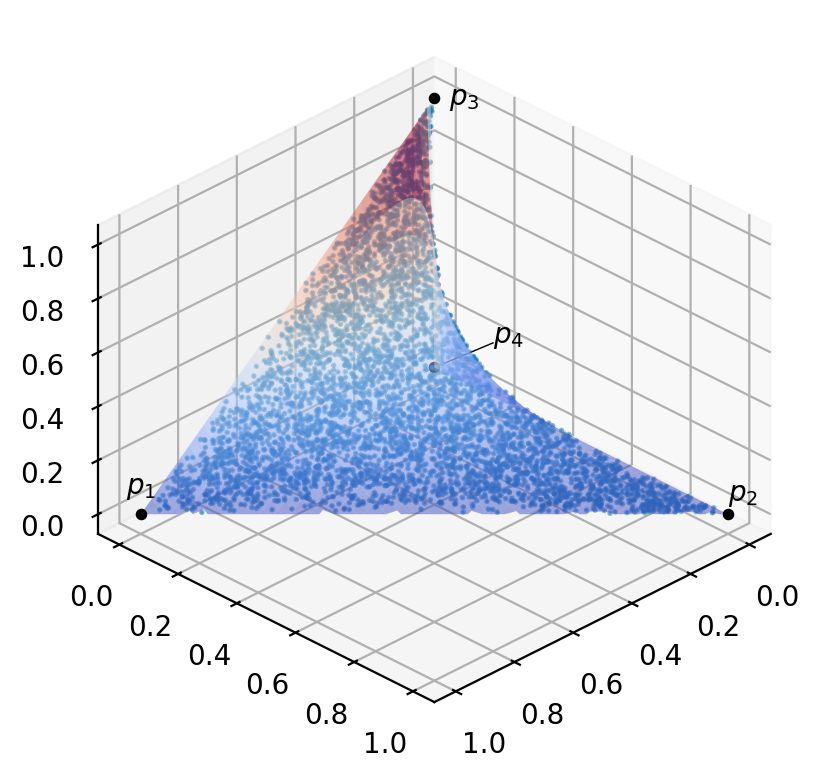

In [7]:
torch.manual_seed(12345)

inputs = torch.randn((5000, 3))
res_x = nn(inputs)
res_x_numpy = res_x.detach().numpy()

ax = plt.figure(dpi=200).add_subplot(projection='3d')
ax.plot_surface(
    *surface,
    cmap=cm.coolwarm,
    alpha=0.5
)
ax.scatter(*res_x_numpy.T, s=1, alpha=0.5)
ax.set_proj_type('ortho')
ax.view_init(elev=30., azim=45)

ax.scatter(0, 0, 0, s=10, c='k', edgecolor='k')
ax.scatter(1, 0, 0, s=10, c='k', edgecolor='k')
ax.scatter(0, 1, 0, s=10, c='k', edgecolor='k')
ax.scatter(0, 0, 1, s=10, c='k', edgecolor='k')

w = 0.05
ax.text(0, 0.2, 0.2, '$p_4$')
ax.plot([0, 0], [0, 0.2], [0, 0.2], c='k', linewidth=0.5)
ax.text(1, -w, w, '$p_1$')
ax.text(0, 1, w, '$p_2$')
ax.text(0, w, 1, '$p_3$')